In [1]:
import gymnasium
from torch.distributions import Normal
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import imageio

In [16]:
env = gymnasium.make("InvertedPendulum-v5", render_mode="rgb_array")

In [3]:
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [4]:
num_iterations = 1000
horizon = 2048
learning_rate = 3e-4
num_epochs = 10
minibatch_size = 64
gamma = 0.99
gae = 0.95

In [5]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim)
        )
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, state):
        mean = self.network(state)
        log_std = self.log_std.expand_as(mean)
        std = torch.exp(log_std)
        return Normal(mean, std)


class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        return self.network(state)

In [6]:
def generate_episode(env, actor, T):
    states, actions, rewards, log_probs = [], [], [], []
    state, _ = env.reset()

    for t in range(T):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        dist = actor(state_tensor)
        action = dist.sample().squeeze(0)
        log_prob = dist.log_prob(action).squeeze()

        next_state, reward, terminated, truncated, info = env.step(action.numpy())
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_probs.append(log_prob)

        done = terminated or truncated
        if done:
            break

        state = next_state

    return (torch.FloatTensor(np.vstack(states)), torch.FloatTensor(np.vstack(actions)), rewards,
            torch.FloatTensor(log_probs))

In [7]:
def compute_rewards_to_go(rewards, gamma=0.99):
    rtg = []
    discounted_sum = 0
    for reward in reversed(rewards):
        discounted_sum = reward + gamma * discounted_sum
        rtg.insert(0, discounted_sum)
    return rtg

In [8]:
def compute_advantages(rewards, values, gamma=0.99, lam=0.95):
    T = len(rewards)
    advantages = torch.zeros(T, dtype=torch.float32)
    gae = 0.0
    for t in reversed(range(T - 1)):
        td_error = rewards[t] + gamma * values[t + 1] - values[t]
        gae = td_error + gamma * lam * gae
        advantages[t] = gae
    return advantages

In [9]:
def update_policy(actor, critic, states, actions, log_probs_old, advantages, rewards_to_go, minibatch_size,
                  clip_param=0.2):
    total_samples = states.size(0)

    for _ in range(num_epochs):
        perm = torch.randperm(total_samples)

        states_perm, actions_perm, log_probs_old_perm, advantages_perm, rewards_to_go_perm = \
            states[perm], actions[perm], log_probs_old[perm], advantages[perm], rewards_to_go[perm]

        # Process each minibatch
        for i in range(0, total_samples, minibatch_size):
            states_batch = states_perm[i:i + minibatch_size]
            actions_batch = actions_perm[i:i + minibatch_size]
            log_probs_old_batch = log_probs_old_perm[i:i + minibatch_size]
            advantages_batch = advantages_perm[i:i + minibatch_size]
            rewards_to_go_batch = rewards_to_go_perm[i:i + minibatch_size]

            # Recompute distribution for current policy
            dist = actor(states_batch)
            log_probs = dist.log_prob(actions_batch).squeeze()

            # Calculate the ratio of new to old probabilities
            ratios = torch.exp(log_probs - log_probs_old_batch.detach())

            # Clipping the ratio to stabilize training
            clipped_ratios = torch.clamp(ratios, 1 - clip_param, 1 + clip_param)

            # Calculate the clipped and unclipped objective
            unclipped_objective = ratios * advantages_batch
            clipped_objective = clipped_ratios * advantages_batch

            # Negative sign to run gradient ascent
            actor_loss = -torch.min(unclipped_objective, clipped_objective).mean()

            values = critic(states_batch).squeeze()

            # Critic loss
            critic_loss = nn.MSELoss()(values, rewards_to_go_batch)

            # Optimize the actor
            actor_optimizer.zero_grad()
            actor_loss.backward(retain_graph=True)
            actor_optimizer.step()

            # Optimize the critic
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

In [10]:
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)
actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
critic_optimizer = optim.Adam(critic.parameters(), lr=learning_rate)

In [11]:
rewards_over_episodes = []

for iteration in range(num_iterations):
    states, actions, rewards, log_probs = generate_episode(env, actor, horizon)

    episode_reward = sum(rewards)
    rewards_over_episodes.append(episode_reward)

    if iteration % 10 == 0:
        print(f"\rEpisode {iteration}: {episode_reward}", end="")

    rewards_to_go = compute_rewards_to_go(rewards)
    rewards_to_go = torch.tensor(rewards_to_go)

    values = critic(states).squeeze()

    advantages = compute_advantages(rewards, values.detach())
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-10)

    update_policy(actor, critic, states, actions, log_probs, advantages, rewards_to_go, minibatch_size)

Episode 50: 17

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 990: 1000

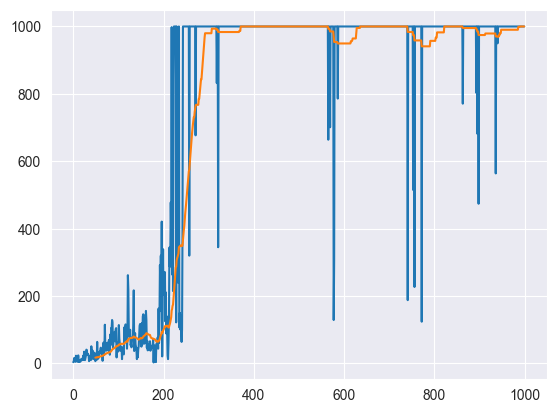

In [19]:
import pandas as pd

plt.plot(rewards_over_episodes)
plt.plot(pd.Series(rewards_over_episodes).rolling(50).mean())
plt.show()

In [17]:
frames = []

state, _ = env.reset()

for _ in range(horizon):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)

    dist = actor(state_tensor)
    action = dist.sample().squeeze(0)
    log_prob = dist.log_prob(action).squeeze()

    next_state, reward, terminated, truncated, info = env.step(action.numpy())

    frame = env.render()
    frames.append(frame)

    done = terminated or truncated
    if done:
        break

    state = next_state

imageio.mimsave("inverted_pendulum.gif", frames, fps=30)

env.close()